주분 2주차 패키지 - 진수정

In [ ]:
import pandas as pd
import numpy as np

# 1. 데이터 분할

- 1.1 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/PSAT/train.csv")
test = pd.read_csv("/content/drive/MyDrive/PSAT/test.csv")

- 1.2 단위 수정

In [ ]:
X_train = train.drop('transaction_year',axis = 1)
Y_train = train['transaction_year']

- 1.3 validation set 분할 - 첫번째

In [ ]:
from sklearn.model_selection import train_test_split

X_tr,X_val,Y_tr,Y_val = train_test_split(X_train,Y_train,test_size = 0.2,random_state = 33)

- 1.4 질문

> train / val에 시간 포인트가 랜덤으로 배정되기 때문에, 미래의 시점을 바탕으로 과거의 시점을 예측하는 문제가 발생할 수 있다.



- 1.5 validation set 분할 - 두번째

In [ ]:
tr_idx = train['transaction_year'] != 4
val_idx = train['transaction_year'] == 4

In [ ]:
X_tr = X_train[tr_idx]
X_val = X_train[val_idx]

Y_tr = Y_train[tr_idx]
Y_val = Y_train[val_idx]

- 1.5 캣부스트 인코딩 전에

In [ ]:
!pip install category_encoders

In [ ]:
from category_encoders.cat_boost import CatBoostEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


- 1.6 캣부스트 인코딩

In [ ]:
cbe_encoder = CatBoostEncoder()

cbe_encoder.fit(X_tr, Y_tr)
train_cbe = cbe_encoder.transform(X_tr)
val_cbe = cbe_encoder.transform(X_val)

In [ ]:
val_cbe.head()

,dong,apt,exclusive_use_area,floor,price,until_trans,sin_date,cos_date
2451,1.799346,1.800803,107.91,14,83000,9,-1.000000e+00,-1.836970e-16
2452,1.799346,1.800803,151.81,10,119000,9,-1.000000e+00,-1.836970e-16
2453,1.799346,1.800803,94.51,2,84500,9,-2.449294e-16,1.000000e+00
2454,1.799346,1.800803,94.28,12,80000,9,-2.449294e-16,1.000000e+00
2455,2.056381,1.995690,145.96,13,121000,13,-1.000000e+00,-1.836970e-16


????????????????????

# 2. 릿지 회귀

- 2.1 상관계수 플랏

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

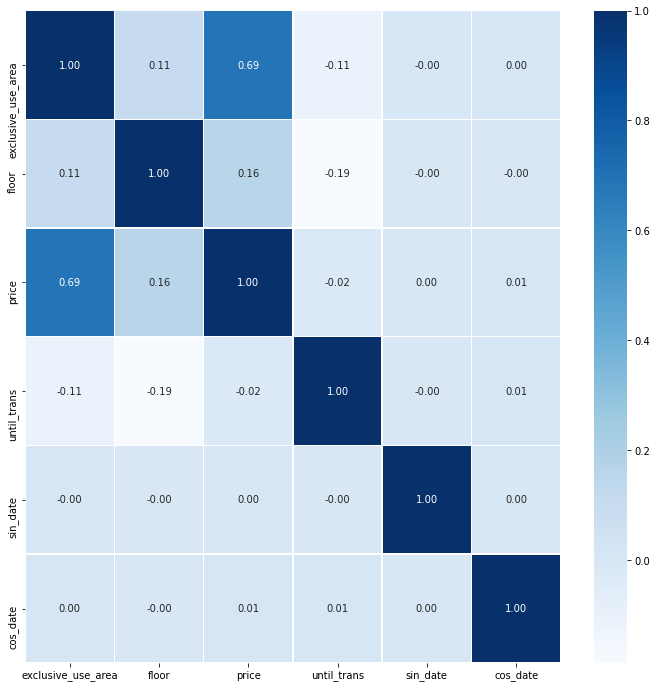

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(data = X_tr.corr(),annot=True,fmt = '.2f',linewidths=.5,cmap='Blues')

> 변수들이 highly correlated 되어 있을 때 릿지 회귀가 효과적이지만, 해당 데이터셋은 그렇지 않기 때문에 릿지 회귀가 잘 작동하지는 않을 것이다.

- 2.2 해석과 무관하게 일단 릿지 튜닝

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1]
rmses = []
coefs = []

for alpha in alphas:
  ridge_reg = Ridge(alpha = alpha,normalize = True)
  ridge_reg.fit(train_cbe,Y_tr)

  Y_pred = ridge_reg.predict(val_cbe)
  mse = mean_squared_error(Y_val,Y_pred)
  rmse = sqrt(mse)
  rmses.append(rmse)

  # For visualization
  coefs.append(ridge_reg.coef_)


- 2.3 튜닝결과 시각화 / 2.4 해석

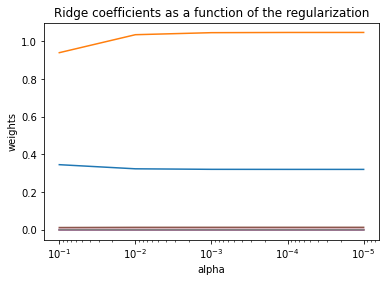

In [ ]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

> alpha가 클수록 계수 추정치가 축소되지만, 0으로 가지는 않는 것을 확인할 수 있다.

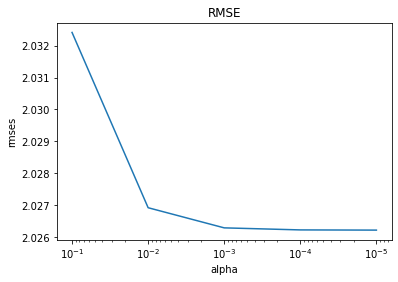

In [ ]:
ax = plt.gca()

ax.plot(alphas, rmses)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('rmses')
plt.title('RMSE')
plt.axis('tight')
plt.show()

In [ ]:
rmses

[2.02622306592163,
 2.026229483267233,
 2.026293553646941,
 2.0269241915222103,
 2.032412785172994]

> alpha = 10^(-5) 일 때 rmse 값이 2.02622306592163 로 가장 작았다.  
> 
-> alpha set 중 최적의 alpha 값은 10^(-5)

- 2.5 그냥 선형 모형으로

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lin_reg = LinearRegression().fit(train_cbe,Y_tr)
Y_pred = lin_reg.predict(val_cbe)
mse = mean_squared_error(Y_val,Y_pred)
rmse = sqrt(mse)

print('RMSE of linear regression model: %.6f'%(rmse))

RMSE of linear regression model: 2.026222


> 선형 모형의 rmse가 릿지 회귀의 rmse 값보다 미세하게 더 작다.  
> 
-> 그냥 선형 모형을 쓰자!

# LGBM

In [ ]:
!pip install lightgbm

- 3.1 LightGBM 이해

LGBM의 
> 특징: 리프 중심 분할 방식을 사용함으로써,   
1) 트리의 깊이가 깊어짐 & 비대칭적 트리 생성  
2) 예측오류를 최소화하며 속도 향상  
> 
> 장점: 속도가 느린 Xgboost의 단점을 개선한 부스팅 방법으로,  
1) 학습하는 데 걸리는 시간이 적으며  
2) 메모리 사용량도 비교적 적은 편이다.
> 
> 문제점: 적은 데이터셋 (일반적으로 10,000건 이하) 에 적용할 경우 과적합 가능성이 크다.

- 3.2 테스트

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMRegressor
# import itertools

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
                     ('lgbmr',LGBMRegressor())
])

In [ ]:
parameters_pipeline = {
    'lgbmr__learning_rate':[0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.99]
}

In [ ]:
grid_search = GridSearchCV(pipeline,parameters_pipeline,n_jobs = -1,cv = 3)
grid_search.fit(train_cbe,Y_tr)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('lgbmr',
                                        LGBMRegressor(boosting_type='gbdt',
                                                      class_weight=None,
                                                      colsample_bytree=1.0,
                                                      importance_type='split',
                                                      learning_rate=0.1,
                                                      max_depth=-1,
                                                      min_child_samples=20,
                                                      min_child_weight=0.001,
                                                      min_split_gain=0.0,
                                                      n_estimators=100,
                                                      n_jobs=-1, num_leaves=31,
                                             

In [ ]:
grid_search.best_params_

{'lgbmr__learning_rate': 0.01}

- 3.2 LGBM 튜닝

In [ ]:
params = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.99]
rmses = []

for param in params:
  lgbmr = LGBMRegressor(learning_rate = param)
  lgbmr.fit(train_cbe,Y_tr)

  Y_pred = lgbmr.predict(val_cbe)
  mse = mean_squared_error(Y_val,Y_pred)
  rmse = sqrt(mse)
  rmses.append(rmse)

- 3.3 튜닝결과 시각화

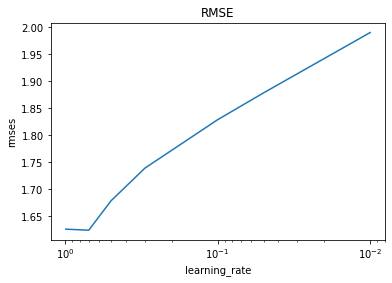

In [ ]:
ax = plt.gca()

ax.plot(params, rmses)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('learning_rate')
plt.ylabel('rmses')
plt.title('RMSE')
plt.axis('tight')
plt.show()

In [ ]:
rmses

[1.9902162893901876,
 1.8785974113961326,
 1.8289485250429909,
 1.7392921936444776,
 1.6789464334976596,
 1.6245011362735131,
 1.6264328304122915]

learning_rate : 0.7

- 3.4 튜닝에 대하여 알아보자

> Grid Search:  
> 탐색의 대상이 되는 파라미터 후보 각각에 대해서 성능을 측정한 후, 가장 높은 성능을 발휘한 파라미터 값을 선정하는 방법  
> 
> 장점: 전역적인 탐색이 가능
> 
> 단점: 탐색 시간이 오래 걸릴 수 있다 & 주관적인 간격 설정
  
> Random Search:  
> 샘플링을 통해 탐색 구간 내의 파라미터 후보를 선정한 후 성능 측정
> 
> 장점: Grid로 제한되지 않음
> 
> 단점: 다음번 파라미터 후보를 선정할 때, 이전까지의 측정 결과에 대한 사전지식이 반영되지 않기 때문에 비효율적인 느낌
  
> Bayesian Optimization
> surrogate model을 통해 현재까지 조사된 데이터를 바탕으로 목적함수를 추정한 후, acquisition function을 통해 다음 입력값을 추천받아 그 관측치를 포함해 다시 목적함수를 추정하는 방법
> 
> 장점: 이전의 탐색결과를 다음 탐색에 반영하면서 최적의 파라미터를 빠르게 탐색한다.
> 
> 단점: 성능이 목적함수의 확률 모델의 파라미터의 값에 민감하다.

# 4. test set

- 4.1 test set 불러오기

> 앞에서 불러왔습니다!

In [ ]:
X_test = test.drop('transaction_year',axis = 1)
Y_test = test['transaction_year']

- 4.2 캣부스트 인코딩

In [ ]:
cbe_encoder = CatBoostEncoder()

cbe_encoder.fit(X_train, Y_train)
train_cbe = cbe_encoder.transform(X_train)
test_cbe = cbe_encoder.transform(X_test)

- 4.3 최적의 파라미터 적합

In [ ]:
# Ridge: 0.00001
ridge_reg = Ridge(alpha = 0.00001,normalize = True)
ridge_reg.fit(train_cbe,Y_train)

Y_pred = ridge_reg.predict(test_cbe)
mse = mean_squared_error(Y_test,Y_pred)
rmse = sqrt(mse)


print('RMSE of ridge regression model: %.6f'%(rmse))

RMSE of ridge regression model: 2.391386


In [ ]:
# Linear regression
lin_reg = LinearRegression().fit(train_cbe,Y_train)
Y_pred = lin_reg.predict(test_cbe)
mse = mean_squared_error(Y_test,Y_pred)
rmse = sqrt(mse)

print('RMSE of linear regression model: %.6f'%(rmse))

RMSE of linear regression model: 2.391384


In [ ]:
# LGBM: learning_rate 0.7
lgbmr = LGBMRegressor(learning_rate = 0.7)
lgbmr.fit(train_cbe,Y_train)

Y_pred = lgbmr.predict(test_cbe)
mse = mean_squared_error(Y_test,Y_pred)
rmse = sqrt(mse)

print('RMSE of LGBM model: %.6f'%(rmse))

RMSE of LGBM model: 1.667552


- 4.4 test set에 대해 평가

> LGBM의 test RMSE가 가장 작으므로, 세 가지 모델 중 최적의 모델이다.